In [11]:
import tensorflow as tf
from tensorflow import keras
from keras.models import load_model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
 
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from tqdm.notebook import tqdm
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
df=pd.read_csv('parkinsons.data')

In [3]:
df

,name,MDVP:Fo(Hz),MDVP:Fhi(Hz),MDVP:Flo(Hz),MDVP:Jitter(%),MDVP:Jitter(Abs),MDVP:RAP,MDVP:PPQ,Jitter:DDP,MDVP:Shimmer,...,Shimmer:DDA,NHR,HNR,status,RPDE,DFA,spread1,spread2,D2,PPE
0,phon_R01_S01_1,119.992,157.302,74.997,0.00784,0.00007,0.00370,0.00554,0.01109,0.04374,...,0.06545,0.02211,21.033,1,0.414783,0.815285,-4.813031,0.266482,2.301442,0.284654
1,phon_R01_S01_2,122.400,148.650,113.819,0.00968,0.00008,0.00465,0.00696,0.01394,0.06134,...,0.09403,0.01929,19.085,1,0.458359,0.819521,-4.075192,0.335590,2.486855,0.368674
2,phon_R01_S01_3,116.682,131.111,111.555,0.01050,0.00009,0.00544,0.00781,0.01633,0.05233,...,0.08270,0.01309,20.651,1,0.429895,0.825288,-4.443179,0.311173,2.342259,0.332634
3,phon_R01_S01_4,116.676,137.871,111.366,0.00997,0.00009,0.00502,0.00698,0.01505,0.05492,...,0.08771,0.01353,20.644,1,0.434969,0.819235,-4.117501,0.334147,2.405554,0.368975
4,phon_R01_S01_5,116.014,141.781,110.655,0.01284,0.00011,0.00655,0.00908,0.01966,0.06425,...,0.10470,0.01767,19.649,1,0.417356,0.823484,-3.747787,0.234513,2.332180,0.410335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
190,phon_R01_S50_2,174.188,230.978,94.261,0.00459,0.00003,0.00263,0.00259,0.00790,0.04087,...,0.07008,0.02764,19.517,0,0.448439,0.657899,-6.538586,0.121952,2.657476,0.133050
191,phon_R01_S50_3,209.516,253.017,89.488,0.00564,0.00003,0.00331,0.00292,0.00994,0.02751,...,0.04812,0.01810,19.147,0,0.431674,0.683244,-6.195325,0.129303,2.784312,0.168895
192,phon_R01_S50_4,174.688,240.005,74.287,0.01360,0.00008,0.00624,0.00564,0.01873,0.02308,...,0.03804,0.10715,17.883,0,0.407567,0.655683,-6.787197,0.158453,2.679772,0.131728
193,phon_R01_S50_5,198.764,396.961,74.904,0.00740,0.00004,0.00370,0.00390,0.01109,0.02296,...,0.03794,0.07223,19.020,0,0.451221,0.643956,-6.744577,0.207454,2.138608,0.123306


In [4]:
#dropping the name colunm
df.drop("name", inplace=True, axis=1)

In [5]:
#Performing Feature Selection with coorelation
columns = list(df.columns)
for col in columns:
    if col == 'status':
        continue
 
    filtered_columns = [col]
    for col1 in df.columns:
        if((col == col1) | (col == 'status')):
            continue
 
        val = df[col].corr(df[col1])
 
        if val > 0.7:
            # If the correlation between the two
            # features is more than 0.7 remove
            columns.remove(col1)
            continue
        else:
            filtered_columns.append(col1)
 
    # After each iteration filter out the columns
    # which are not highly correlated features.
    df = df[filtered_columns]


In [6]:
#Using Chi-Square
#reducing the feature space up to 7 by using the chi-square test.
X = df.drop('status', axis=1)
X_norm = MinMaxScaler().fit_transform(X)
selector = SelectKBest(chi2, k=6)
selector.fit(X_norm, df['status'])
filtered_columns = selector.get_support()
filtered_data = X.loc[:, filtered_columns]
filtered_data['status'] = df['status']
df = filtered_data
df.shape

/var/folders/9y/610tzfp14gv7y3_n3zqsfvv80000gn/T/ipykernel_61678/634840123.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['status'] = df['status']


(195, 7)

In [7]:
features = df.drop('status', axis=1)
target = df['status']

In [8]:
ros = RandomOverSampler(sampling_strategy='minority',
                        random_state=0)
X, Y = ros.fit_resample(features, target)
X.shape, Y.shape

((294, 6), (294,))

In [9]:
X_train, X_val,Y_train, Y_val = train_test_split(X, Y,test_size=0.2,random_state=10)
X_train.shape, X_val.shape

((235, 6), (59, 6))

In [23]:
#using nural network
# Defining the model
model_self = keras.Sequential([
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation='relu'),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(50, activation='relu'),
    keras.layers.Dense(30, activation = 'sigmoid'),
    keras.layers.Dense(20, activation = 'relu'),
    keras.layers.Dropout(0.05),
    keras.layers.Dense(1, activation = 'sigmoid')
])


In [24]:
model_self.compile(optimizer='adam', loss='BinaryCrossentropy', metrics=['accuracy'])

In [25]:
gra = model_self.fit(X_train, Y_train, epochs=200,validation_data=(X_val,Y_val), batch_size=128)

Epoch 1/200


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x128x1x20xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerforma

1/2 [==============>...............] - ETA: 6s - loss: 0.7283 - accuracy: 0.4766

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x107x1x100xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x107x1x20xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerforma

2/2 [==============================] - ETA: 0s - loss: 0.7206 - accuracy: 0.4766

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x59x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/75428952-3aa4-11ee-8b65-46d450270006/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x59x1x1xi1>'


2/2 [==============================] - 11s 4s/step - loss: 0.7206 - accuracy: 0.4766 - val_loss: 0.6842 - val_accuracy: 0.6102
Epoch 2/200
2/2 [==============================] - 0s 28ms/step - loss: 0.6985 - accuracy: 0.4766 - val_loss: 0.6769 - val_accuracy: 0.6102
Epoch 3/200
2/2 [==============================] - 0s 32ms/step - loss: 0.6884 - accuracy: 0.4979 - val_loss: 0.6718 - val_accuracy: 0.6102
Epoch 4/200
2/2 [==============================] - 0s 27ms/step - loss: 0.6674 - accuracy: 0.6043 - val_loss: 0.6680 - val_accuracy: 0.6102
Epoch 5/200
2/2 [==============================] - 0s 26ms/step - loss: 0.6508 - accuracy: 0.6894 - val_loss: 0.6658 - val_accuracy: 0.6102
Epoch 6/200
2/2 [==============================] - 0s 28ms/step - loss: 0.6466 - accuracy: 0.7191 - val_loss: 0.6669 - val_accuracy: 0.6102
Epoch 7/200
2/2 [==============================] - 0s 28ms/step - loss: 0.6404 - accuracy: 0.7234 - val_loss: 0.6698 - val_accuracy: 0.6102
Epoch 8/200
2/2 [================

2/2 [==============================] - 0s 27ms/step - loss: 0.1164 - accuracy: 0.9617 - val_loss: 0.4653 - val_accuracy: 0.8136
Epoch 118/200
2/2 [==============================] - 0s 25ms/step - loss: 0.1262 - accuracy: 0.9660 - val_loss: 0.4594 - val_accuracy: 0.8136
Epoch 119/200
2/2 [==============================] - 0s 25ms/step - loss: 0.1393 - accuracy: 0.9489 - val_loss: 0.4550 - val_accuracy: 0.8136
Epoch 120/200
2/2 [==============================] - 0s 26ms/step - loss: 0.1341 - accuracy: 0.9574 - val_loss: 0.4489 - val_accuracy: 0.8136
Epoch 121/200
2/2 [==============================] - 0s 25ms/step - loss: 0.1704 - accuracy: 0.9362 - val_loss: 0.4500 - val_accuracy: 0.8136
Epoch 122/200
2/2 [==============================] - 0s 25ms/step - loss: 0.1377 - accuracy: 0.9532 - val_loss: 0.4449 - val_accuracy: 0.8305
Epoch 123/200
2/2 [==============================] - 0s 24ms/step - loss: 0.1390 - accuracy: 0.9489 - val_loss: 0.4434 - val_accuracy: 0.8305
Epoch 124/200
2/2 [=

Epoch 175/200
2/2 [==============================] - 0s 26ms/step - loss: 0.1037 - accuracy: 0.9660 - val_loss: 0.2597 - val_accuracy: 0.9322
Epoch 176/200
2/2 [==============================] - 0s 26ms/step - loss: 0.1075 - accuracy: 0.9574 - val_loss: 0.2568 - val_accuracy: 0.9322
Epoch 177/200
2/2 [==============================] - 0s 25ms/step - loss: 0.1239 - accuracy: 0.9574 - val_loss: 0.2517 - val_accuracy: 0.9322
Epoch 178/200
2/2 [==============================] - 0s 26ms/step - loss: 0.0888 - accuracy: 0.9702 - val_loss: 0.2468 - val_accuracy: 0.9322
Epoch 179/200
2/2 [==============================] - 0s 25ms/step - loss: 0.1565 - accuracy: 0.9532 - val_loss: 0.2426 - val_accuracy: 0.9322
Epoch 180/200
2/2 [==============================] - 0s 25ms/step - loss: 0.1042 - accuracy: 0.9617 - val_loss: 0.2396 - val_accuracy: 0.9322
Epoch 181/200
2/2 [==============================] - 0s 26ms/step - loss: 0.1017 - accuracy: 0.9617 - val_loss: 0.2361 - val_accuracy: 0.9322
Epoch 

In [27]:
gra.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [28]:
gra

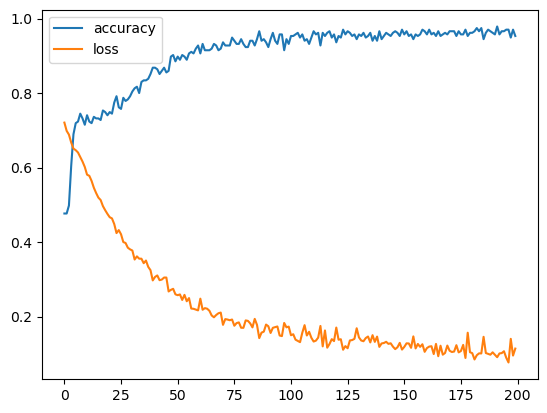

In [32]:
plt.plot(gra.history['accuracy'])
plt.plot(gra.history['loss'])
plt.legend(["accuracy","loss"])
plt.savefig("parkinsons_ann_acc_v1.png")

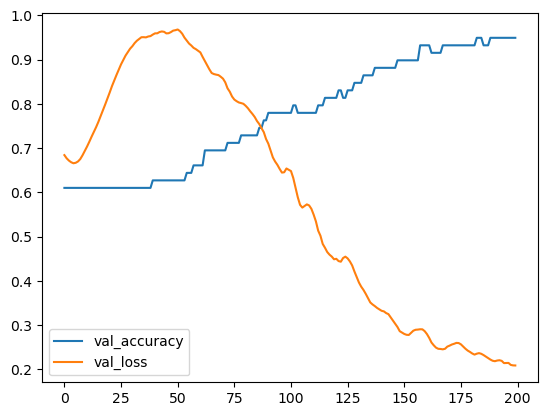

In [33]:
plt.plot(gra.history['val_accuracy'])
plt.plot(gra.history['val_loss'])
plt.legend(["val_accuracy","val_loss"])
plt.savefig("parkinsons_ann_val_v1.png")

2/2 [==============================] - 0s 31ms/step


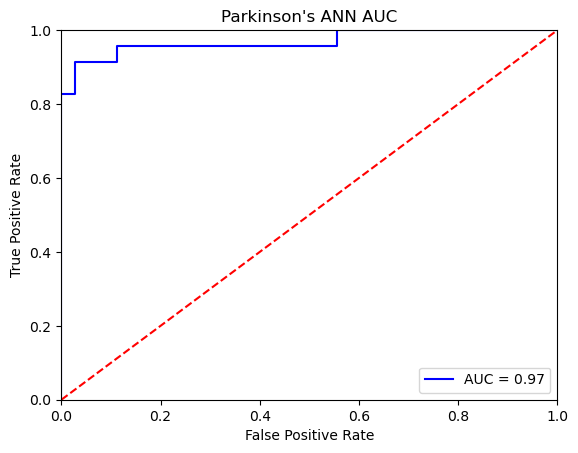

In [120]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
probs = model_self.predict(X_val)
preds = probs[:,0]
fpr, tpr, threshold = metrics.roc_curve(Y_val, preds)
roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title("Parkinson's ANN AUC")
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

plt.savefig("parkinsons_ann_auc.png")

In [4]:
"""from sklearn.metrics import roc_auc_score as ras
models = [LogisticRegression(), XGBClassifier()]
 
for i in range(len(models)):
    models[i].fit(X_train, Y_train)
 
    print(f'{models[i]} : ')
 
    train_preds = models[i].predict_proba(X_train)[:, 1]
    print('Training Accuracy : ', ras(Y_train, train_preds))
 
    val_preds = models[i].predict_proba(X_val)[:, 1]
    print('Validation Accuracy : ', ras(Y_val, val_preds))"""

"from sklearn.metrics import roc_auc_score as ras\nmodels = [LogisticRegression(), XGBClassifier()]\n \nfor i in range(len(models)):\n    models[i].fit(X_train, Y_train)\n \n    print(f'{models[i]} : ')\n \n    train_preds = models[i].predict_proba(X_train)[:, 1]\n    print('Training Accuracy : ', ras(Y_train, train_preds))\n \n    val_preds = models[i].predict_proba(X_val)[:, 1]\n    print('Validation Accuracy : ', ras(Y_val, val_preds))"

In [43]:
probs.shape

(59, 1)

In [44]:
probs[:,0]

array([0.1223343 , 0.993006  , 0.9968336 , 0.99848574, 0.01703342,
       0.00263139, 0.235359  , 0.9932114 , 0.00264504, 0.85805225,
       0.04930161, 0.9985318 , 0.971024  , 0.00247245, 0.99903786,
       0.1223343 , 0.00253805, 0.00270644, 0.99750537, 0.00280383,
       0.01683465, 0.55136544, 0.31873104, 0.00299786, 0.10583963,
       0.00269988, 0.00420213, 0.99342316, 0.3620708 , 0.00269025,
       0.9569967 , 0.00297941, 0.2442953 , 0.99845314, 0.00330719,
       0.00565477, 0.00349283, 0.02741104, 0.9930975 , 0.00253805,
       0.6182184 , 0.00314545, 0.00565477, 0.00794157, 0.9998275 ,
       0.9980843 , 0.00267909, 0.99751663, 0.10583963, 0.12208337,
       0.00365318, 0.12208337, 0.98753405, 0.9754092 , 0.9657034 ,
       0.00297941, 0.00766463, 0.00794157, 0.99980015], dtype=float32)

2/2 [==============================] - 0s 16ms/step


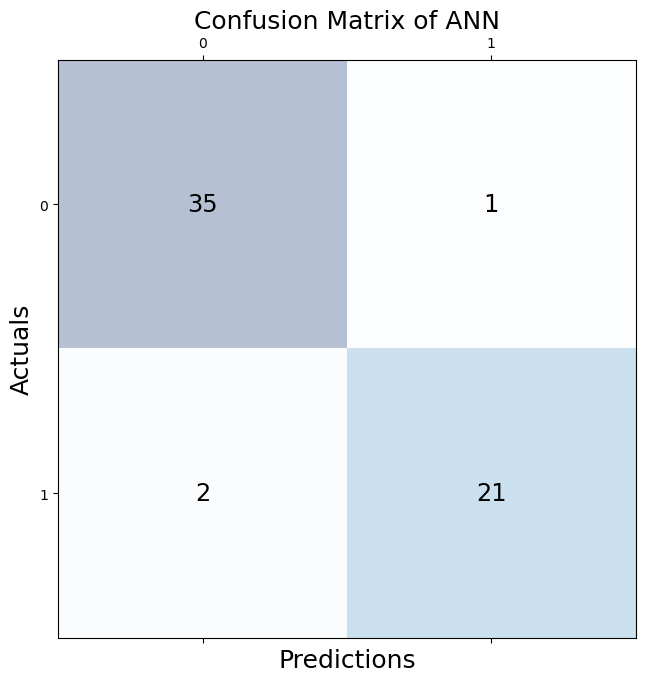

In [100]:
y_pred = model_self.predict(X_val)
for i in range(len(y_pred)):
    if y_pred[i,0] > 0.5:
        y_pred[i,0]=1
    else:
        y_pred[i,0]=0

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(Y_val, y_pred)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix of ANN', fontsize=18)
plt.savefig('confusion_ann_parkinsons.png')
plt.show()

In [60]:
output = model_self.predict(X_val)
for i in range(len(output)):
    if output[i,0] > 0.5:
        output[i,0]=1
    else:
        output[i,0]=0

2/2 [==============================] - 0s 4ms/step


In [64]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier

In [111]:
clf1 = LogisticRegression(penalty='l2',C=1)
clf2 = GaussianNB()
clf3 = RandomForestClassifier(criterion='entropy', n_estimators=10)
clf4 = AdaBoostClassifier(n_estimators=600,learning_rate=0.001, random_state=1)

In [112]:
models = [clf1,clf2,clf3,clf4]
accuracy ={}
for i in models:
    
    i.fit(X_train, Y_train)
    accuracy[i] = i.score(X_val,Y_val)

In [113]:
accuracy

{LogisticRegression(C=1): 0.7288135593220338,
 GaussianNB(): 0.7457627118644068,
 RandomForestClassifier(criterion='entropy', n_estimators=10): 0.9152542372881356,
 AdaBoostClassifier(learning_rate=0.001, n_estimators=600, random_state=1): 0.7457627118644068}

In [115]:
y_pred_lr=clf1.predict(X_val)
y_pred_gassNB=clf2.predict(X_val)
y_pred_rf=clf3.predict(X_val)
y_pred_adaboost=clf4.predict(X_val)

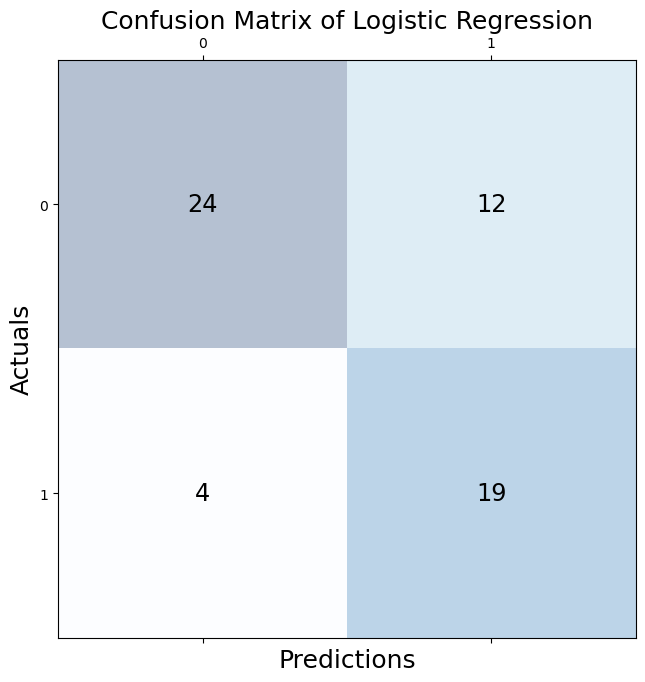

In [101]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(Y_val, y_pred_lr)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix of Logistic Regression', fontsize=18)
plt.savefig('cm_lr.png')
plt.show()

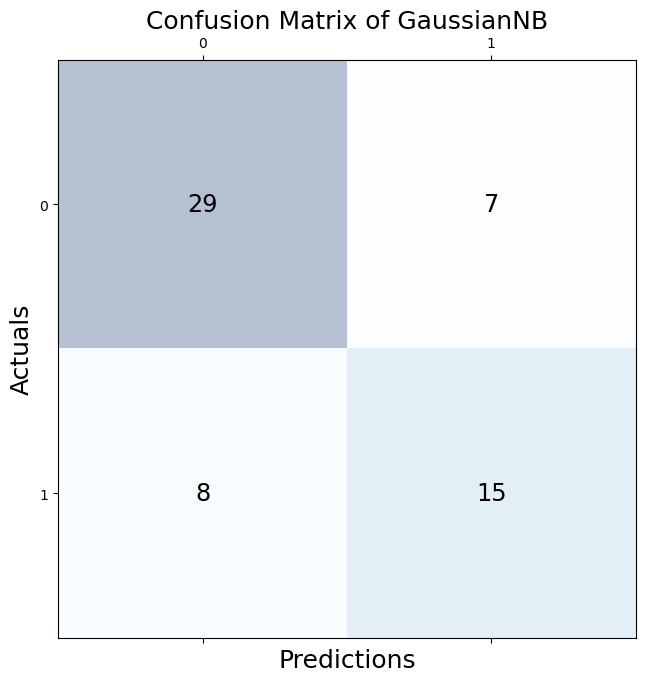

In [102]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(Y_val, y_pred_gassNB)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix of GaussianNB', fontsize=18)
plt.savefig('cm_gassNB.png')
plt.show()

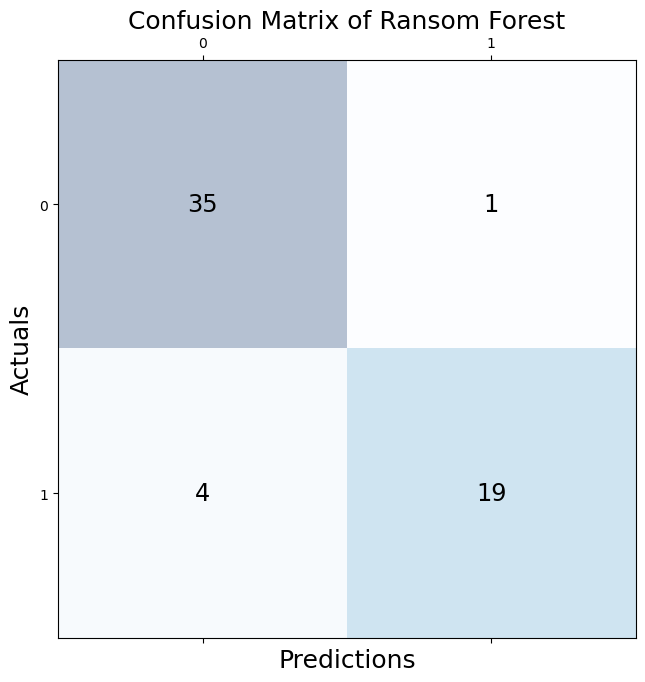

In [116]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(Y_val, y_pred_rf)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix of Ransom Forest', fontsize=18)
plt.savefig('cm_rf.png')
plt.show()

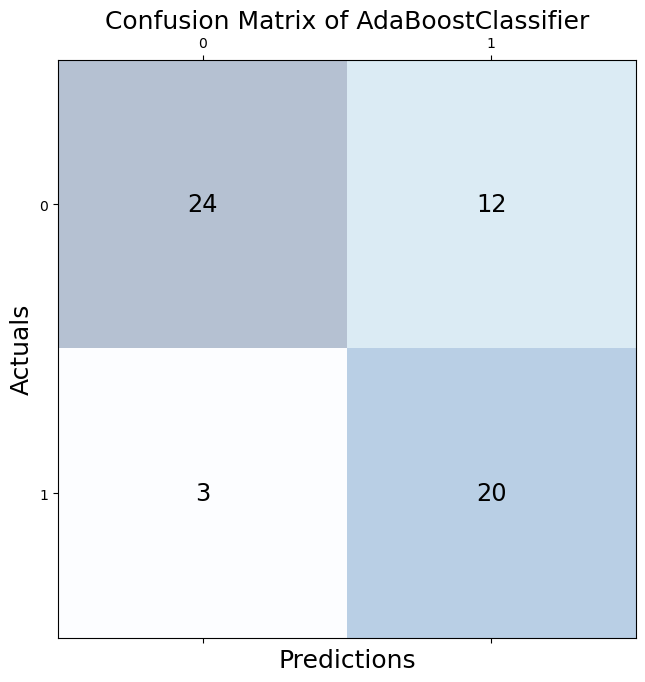

In [104]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(Y_val, y_pred_adaboost)
fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(cm, cmap=plt.cm.Blues, alpha=0.3)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix of AdaBoostClassifier', fontsize=18)
plt.savefig('cm_adaboost.png')
plt.show()